In [1]:
import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf

In [2]:
df = pdr.get_data_yahoo("AAPL", start="2019-01-01" , end = '2021-01-01')
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
Date,,,,
2019-01-02,0.0,39.480000,NaN,NaN
2019-01-03,0.0,35.547501,NaN,NaN
2019-01-04,0.0,37.064999,NaN,NaN
2019-01-07,0.0,36.982498,NaN,NaN
2019-01-08,0.0,37.687500,NaN,NaN
...,...,...,...,...
2020-12-24,-1.0,131.970001,131.880005,108.769997
2020-12-28,-1.0,136.690002,131.970001,108.769997
2020-12-29,0.0,134.869995,136.690002,108.769997


In [7]:
def buy_stock(
    historical_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    when the signal is on, the agent trade shares
    
    historical_movement = historical movement
    min_holding_period = minimum interval between decision of buy and sell, vice versa
    state = 1 is buy, 0 is sell
    initial_money = 10000
    max_buy = max shares to buy, i long the market and growth of market thus i set max buy > max sell
    max_sell = max shares to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // historical_movement[i]
        if shares < 1:
            0
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * historical_movement[i]
            current_inventory += buy_units

            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(historical_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    0
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * historical_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (historical_movement[i] - historical_movement[states_buy[-1]])
                        / historical_movement[states_buy[-1]]
                    ) 
                except:
                    invest = 0
      
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) 
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

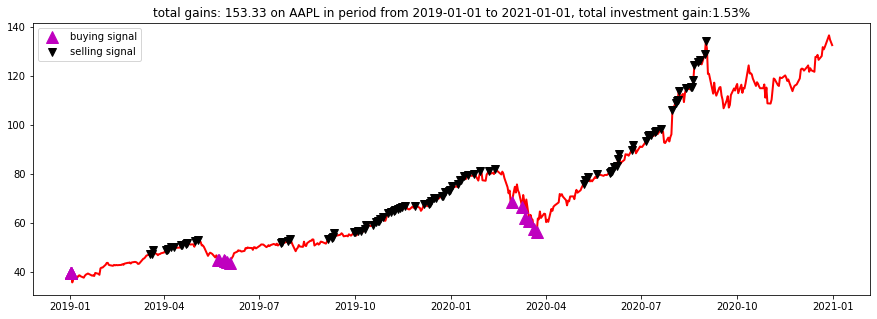

In [8]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=12, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=8, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains: {:.2f} on AAPL in period from 2019-01-01 to 2021-01-01, total investment gain:{:.2%}'.format(total_gains, invest))
plt.legend()
plt.show()
